## **Heart Disease Prediction using Spark MLlib**

__Objective:__ The objective of this project is to build various models for heart disease prediction using Logistic Regression, Decision Tree, Random Forest and Gradient-Boosted Tree using the dataset obtain from Kaggle. These models will be evaluated based on their performance on both tranining and testing sets to know which machine learning algorithm is best for predicting heart disease.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data_visualization as dv
import data_preprocessing as dp
import utils
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import PCA, StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.linalg import Vectors, DenseVector, VectorUDT
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import roc_curve, auc

### __Importing Dataset__

The dataset was obtained from https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease. It is about the Key Heart Disease Indicators, sourced from the 2022 CDC survey involving over 400,000 adults, which primarily examines health-related factors that cause heart disease. Globally, heart disease ranks among the top causes of death across different racial groups, with major risk factors such as high blood pressure, high cholesterol levels, and smoking. Other significant contributors to heart disease include diabetes, obesity, lack of physical activity, and excessive alcohol consumption are taken into consideration. 

In [2]:
# Initializing Spark session
spark = utils.initialize_spark_session()

# Open file for heart disease key indicators
filename = "dataset/heart_2022_with_nans.csv"
heart_disease_df = utils.open_csv(spark, filename)
heart_disease_df.show(5)

+-------+------+-------------+------------------+----------------+--------------------+------------------+----------+------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+--------------------+--------------------+---------+---------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+--------------------+----------------+--------+
|  State|   Sex|GeneralHealth|PhysicalHealthDays|MentalHealthDays|     LastCheckupTime|PhysicalActivities|SleepHours|RemovedTeeth|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDressingBathing|Diffi

In [3]:
heart_disease_df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: double (nullable = true)
 |-- MentalHealthDays: double (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: double (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

We'll use the same set of features (18 in total) from the 2020 dataset to simplify the analysis. Therefore, we'll exclude additional features introduced in the 2022 dataset, except for `HeightInMeters` and `WeightInKilograms`. These two features are important for calculating missing values in the `BMI` field.

In [4]:
del_columns = ['State', 'LastCheckupTime', 'RemovedTeeth', 'HadDepressiveDisorder', 'HadArthritis', 'HadAngina', 'HadCOPD', 
               'DeafOrHardOfHearing', 'ECigaretteUsage', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'ChestScan',
               'DifficultyDressingBathing', 'DifficultyErrands', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'CovidPos',
               'TetanusLast10Tdap', 'HighRiskLastYear']

heart_disease_df = heart_disease_df.drop(*del_columns)
print(f"Number of features: {len(heart_disease_df.columns)}")

Number of features: 20


In [5]:
# Dimension of the dataset
print(f"Shape of the Heart Disease dataset: ({heart_disease_df.count()}, {len(heart_disease_df.columns)})")

Shape of the Heart Disease dataset: (445132, 20)


### __Exploratory Data Analysis__

View the basic statistical details of the dataset

In [6]:
heart_disease_df.summary().show()

+-------+------+-------------+------------------+-----------------+------------------+------------------+--------------+---------+---------+-------------+----------------+--------------------+-----------------+--------------------+---------------------+---------------+-------------------+------------------+------------------+---------------+
|summary|   Sex|GeneralHealth|PhysicalHealthDays| MentalHealthDays|PhysicalActivities|        SleepHours|HadHeartAttack|HadStroke|HadAsthma|HadSkinCancer|HadKidneyDisease|         HadDiabetes|DifficultyWalking|        SmokerStatus|RaceEthnicityCategory|    AgeCategory|     HeightInMeters| WeightInKilograms|               BMI|AlcoholDrinkers|
+-------+------+-------------+------------------+-----------------+------------------+------------------+--------------+---------+---------+-------------+----------------+--------------------+-----------------+--------------------+---------------------+---------------+-------------------+------------------+----

Drop all duplicate records from the dataset

In [7]:
print(f"Record count before dropping duplicates => {heart_disease_df.count()}")
heart_disease_df = heart_disease_df.dropDuplicates()
print(f"Record count after dropping duplicates  => {heart_disease_df.count()}")

Record count before dropping duplicates => 445132
Record count after dropping duplicates  => 431009


Check all records with missing (or null) values

In [8]:
print("List of features with missing values:")
for col_ in heart_disease_df.columns:
    null_values_count = heart_disease_df.filter(heart_disease_df[col_].isNull()).count()
    if null_values_count != 0:
        print(f"- '{col_}' : {null_values_count}")

List of features with missing values:


- 'GeneralHealth' : 1175
- 'PhysicalHealthDays' : 10897
- 'MentalHealthDays' : 9038
- 'PhysicalActivities' : 1069
- 'SleepHours' : 5413
- 'HadHeartAttack' : 3038
- 'HadStroke' : 1530
- 'HadAsthma' : 1746
- 'HadSkinCancer' : 3116
- 'HadKidneyDisease' : 1899
- 'HadDiabetes' : 1060
- 'DifficultyWalking' : 19808
- 'SmokerStatus' : 31136
- 'RaceEthnicityCategory' : 13740
- 'AgeCategory' : 8444
- 'HeightInMeters' : 23814
- 'WeightInKilograms' : 36714
- 'BMI' : 43426
- 'AlcoholDrinkers' : 42185


There are 3,038 records with missing values found in `HadHeartAttack`, which is the target variable. Hence, we can simply drop all those records, keeping only the records with assigned class labels.

In [9]:
print(f"Record count before dropping null values in `HadHeartAttack` => {heart_disease_df.count()}")
heart_disease_df = heart_disease_df.na.drop(subset=["HadHeartAttack"])
print(f"Record count after dropping null values in `HadHeartAttack`  => {heart_disease_df.count()}")

Record count before dropping null values in `HadHeartAttack` => 431009


Record count after dropping null values in `HadHeartAttack`  => 427971


Check if the target variable `HadHeartAttack` is a binary, wherein it should only have two distinct values, i.e. Yes and No. This feature will be used to predict whether a person has heart disease or not.

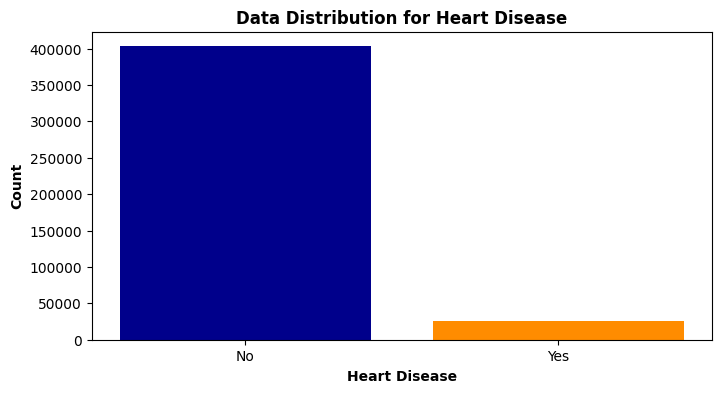

In [10]:
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadHeartAttack", 
                  figure_size=(8,4),
                  title='Data Distribution for Heart Disease', 
                  x_label='Heart Disease', 
                  x_tick_rotation=None,
                  bar_color=['darkblue', 'darkorange'])

__Observation:__ The chart reveals that there is an imbalance in the number of records for `HadHeartAttack`, showing an uneven distribution of data between individuals who have the illness and those who do not. This could cause the trained model's predictions for heart disease to be severely biased. Ways to fix imbalanced dataset include oversampling minority class, undersampling majority class, adding class weight, generating synthetic samples, etc. We will be using __*oversampling*__ approach to avoid losing information from the majority class.

##### __Limiting Data to a Specific Ethnicity__

When building a model for heart disease, considering a particular ethnicity is very important because different ethnic groups can have distinct genetic, lifestyle, and environmental factors that influence the health of the heart. By focusing on a specific ethnicity, we can develop more personalized and accurate models that account for unique risk factors and characteristics within that population.

In [11]:
heart_disease_df.groupBy("RaceEthnicityCategory").count().orderBy("count").show(truncate=False)

+-----------------------------+------+
|RaceEthnicityCategory        |count |
+-----------------------------+------+
|Multiracial, Non-Hispanic    |9498  |
|null                         |13408 |
|Other race only, Non-Hispanic|22195 |
|Black only, Non-Hispanic     |34793 |
|Hispanic                     |41980 |
|White only, Non-Hispanic     |306097|
+-----------------------------+------+



Therefore, we'll focus solely on the most number of records for racial group, which is `White only, Non-Hispanic`.

In [12]:
print(f"Record count before dropping null values in `RaceEthnicityCategory` => {heart_disease_df.count()}")
heart_disease_df = heart_disease_df.filter(col("RaceEthnicityCategory") == "White only, Non-Hispanic")
print(f"Record count after dropping null values in `RaceEthnicityCategory`  => {heart_disease_df.count()}")

Record count before dropping null values in `RaceEthnicityCategory` => 427971
Record count after dropping null values in `RaceEthnicityCategory`  => 306097


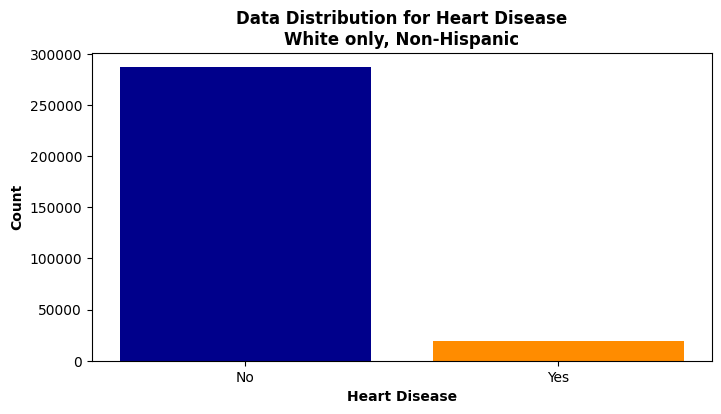

In [13]:
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadHeartAttack", 
                  figure_size=(8,4),
                  title='Data Distribution for Heart Disease\nWhite only, Non-Hispanic', 
                  x_label='Heart Disease', 
                  x_tick_rotation=None,
                  bar_color=['darkblue', 'darkorange'])

##### __Data Imputation for Missing Values__

Data imputation is the process of filling in missing values in a dataset. When there are gaps or null values in the data, an imputer helps estimate or replace those missing values with reasonable substitutes based on the available information.

----------------


__i. Data Imputatifor Height and Weight__

Check the skewness of `HeightInMeters` and `WeightInKilograms` within each age category to decide on the appropriate imputation method. Based from the results, majority of height values are slightly skewed to the left, while all weight values are skewed to the right. Therefore, __*median*__ imputation will be used to address the missing values in both height and weight as it is more sensitive to outliers than the mean.

__Skewness Interpretation:__
- If skewness is close to 0, it suggests a relatively symmetrical distribution.
- If skewness is significantly positive, it indicates a right-skewed distribution.
- If skewness is significantly negative, it indicates a left-skewed distribution.

In [14]:
window_spec = Window.partitionBy("Sex", "AgeCategory")

# Calculate skewness and median using window functions
skewness_df = heart_disease_df\
    .withColumn("HeightSkewness", round(skewness("HeightInMeters").over(window_spec), 4))\
    .withColumn("HeightMedian", median("HeightInMeters").over(window_spec))\
    .withColumn("HeightCount", count("HeightInMeters").over(window_spec))\
    .withColumn("WeightSkewness", round(skewness("WeightInKilograms").over(window_spec), 4))\
    .withColumn("WeightMedian", median("WeightInKilograms").over(window_spec))\
    .withColumn("WeightCount", count("WeightInKilograms").over(window_spec))\
    .select("Sex", "AgeCategory", "HeightSkewness", "HeightCount", "HeightMedian", "WeightSkewness", "WeightCount", "WeightMedian")\
    .distinct().orderBy("Sex", "AgeCategory")

print("Statistical analysis on height and weight based on sex and age category")
skewness_df.show(30)

Statistical analysis on height and weight based on sex and age category
+------+---------------+--------------+-----------+------------+--------------+-----------+------------+
|   Sex|    AgeCategory|HeightSkewness|HeightCount|HeightMedian|WeightSkewness|WeightCount|WeightMedian|
+------+---------------+--------------+-----------+------------+--------------+-----------+------------+
|Female|           null|       -0.1963|       1922|        1.63|        2.4783|       1342|       65.32|
|Female|   Age 18 to 24|        -0.013|       6069|        1.65|        1.3508|       5876|       66.68|
|Female|   Age 25 to 29|        0.0678|       5478|        1.65|        1.2612|       5301|       72.57|
|Female|   Age 30 to 34|        0.1106|       7095|        1.65|        1.3515|       6792|       72.57|
|Female|   Age 35 to 39|        0.1009|       8395|        1.65|        1.3903|       7973|       73.94|
|Female|   Age 40 to 44|       -0.1585|       9281|        1.65|        1.3257|       87

In [15]:
# Median imputation will be used for both height and weight due to skewed dataset
heart_disease_df = dp.impute_biometrics(heart_disease_df, skewness_df, "HeightInMeters", "HeightMedian")
heart_disease_df = dp.impute_biometrics(heart_disease_df, skewness_df, "WeightInKilograms", "WeightMedian")

missing_val_height = utils.count_missing_values(heart_disease_df, "HeightInMeters")
missing_val_weight = utils.count_missing_values(heart_disease_df, "WeightInKilograms")
print(f"Check for missing values in `HeightInMeters`: {missing_val_height} and `WeightInKilograms`: {missing_val_weight}")

# NOTE: Performing a file checkpoint and spark restart actions due to the issue related to garbage collection
checkpoint_ctr = 1
heart_disease_df, spark = utils.data_checkpoint(spark, heart_disease_df, checkpoint_ctr)

Check for missing values in `HeightInMeters`: 0 and `WeightInKilograms`: 0


__ii. Data Imputation for BMI__

Body Mass Index (BMI) is a metric calculated based on a person's weight and height. The BMI is often used as an indicator of body fatness and is a screening tool to categorize individuals into different weight status categories, such as underweight, normal weight, overweight, and obesity. The formula is:

$$ BMI = {WeightInKilograms \over HeightInMeters^2} $$

To fill in the missing values in BMI, we will calculate BMI by using the given formula above, basing on individual's weight and height.

In [16]:
print(f"Record count with missing BMI before data imputation => {utils.count_missing_values(heart_disease_df, 'BMI')}")
heart_disease_df = dp.impute_bmi(heart_disease_df)
print(f"Record count with missing BMI after data imputation  => {utils.count_missing_values(heart_disease_df, 'BMI')}")

Record count with missing BMI before data imputation => 25968
Record count with missing BMI after data imputation  => 0


Use boxplot to check whether there are any outliers present in the BMI dataset. From the chart, a number of outliers are shown due to imbalance data distribution for people with heart disease. Hence, we'll consider the data an outlier if BMI value is more than 100.

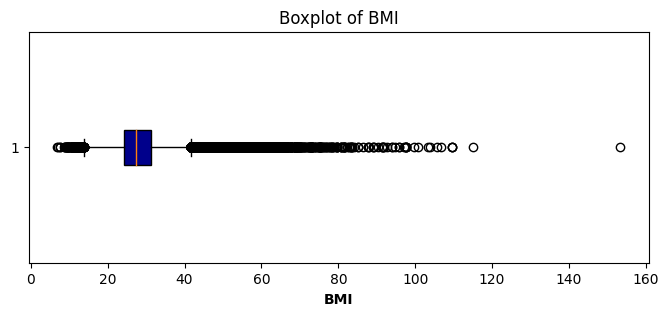

In [17]:
# Create a boxplot using Matplotlib
bmi_data = heart_disease_df.select("BMI").rdd.flatMap(lambda x: x).collect()
dv.show_boxplot_graph(data=bmi_data, figure_size=(8,3), title='Boxplot of BMI', x_label='BMI')

In [18]:
# Remove outliers from BMI dataset with BMI greater than 100
heart_disease_df = heart_disease_df.filter(col("BMI") <= 100)
heart_disease_df.select(min(col("BMI")), max(col("BMI"))).show()

+-----------------+--------+
|         min(BMI)|max(BMI)|
+-----------------+--------+
|6.768013327780092|   99.64|
+-----------------+--------+



__iii. Data Imputation for Age Category__

To fill in the missing age group values, a new column named `WeightStatus` will be created first where its values, deriving the values from BMI. The BMI interpretation is based on guidelines available at https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html." 
- Underweight: 0 to 18.59
- Healthy Weight: 18.6 to 24.99
- Overweight: 25.0 to 29.99
- Obesity: 30.0 and above

This new column will be part of the aggregation to get the age category with the highest count.

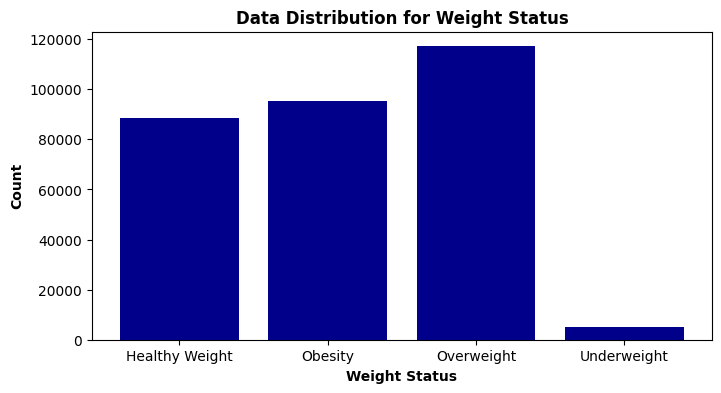

In [19]:
# Create a new column `WeightStatus` with values based from BMI
heart_disease_df = heart_disease_df.withColumn("WeightStatus", 
    when(format_number(col("BMI"), 2).between(0, 18.59), "Underweight")
    .when(format_number(col("BMI"), 2).between(18.6, 24.99), "Healthy Weight")
    .when(format_number(col("BMI"), 2).between(25.0, 29.99), "Overweight")
    .when(format_number(col("BMI"), 2).between(30.0, 200), "Obesity"))
    
# Show data distribution of weight status
dv.show_bar_graph(df=heart_disease_df, 
                  col_="WeightStatus", 
                  figure_size=(8,4),
                  title='Data Distribution for Weight Status', 
                  x_label='Weight Status')

For each combination of `Sex`, `WeightStatus`, and `AgeCategory`, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the `AgeCategory` will be imputed based on the subgroup.

*Example: Majority of underweight females fall into the 'Age 80 or older' category. Hence, that specific age category value will be used to replace the missing data for underweight females.*

In [20]:
print("Statistical analysis for age group based on sex and weight status")
age_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "WeightStatus", "AgeCategory")
age_result.show()

Statistical analysis for age group based on sex and weight status


+------+--------------+---------------+-----+
|   Sex|  WeightStatus|    AgeCategory|count|
+------+--------------+---------------+-----+
|Female|Healthy Weight|Age 80 or older| 7609|
|Female|       Obesity|   Age 65 to 69| 6041|
|Female|    Overweight|   Age 65 to 69| 6927|
|Female|   Underweight|Age 80 or older|  696|
|  Male|Healthy Weight|   Age 18 to 24| 4065|
|  Male|       Obesity|   Age 65 to 69| 5806|
|  Male|    Overweight|   Age 65 to 69| 7231|
|  Male|   Underweight|   Age 18 to 24|  401|
+------+--------------+---------------+-----+



In [21]:
# Impute age category based on sex and weight status
print("Number of missing values in AgeCategory before imputation: ", utils.count_missing_values(heart_disease_df, 'AgeCategory'))
heart_disease_df = dp.impute_based_on_sws(heart_disease_df, age_result, "AgeCategory")
print("Number of missing values in AgeCategory before imputation: ", utils.count_missing_values(heart_disease_df, 'AgeCategory'))

Number of missing values in AgeCategory before imputation:  4648
Number of missing values in AgeCategory before imputation:  0


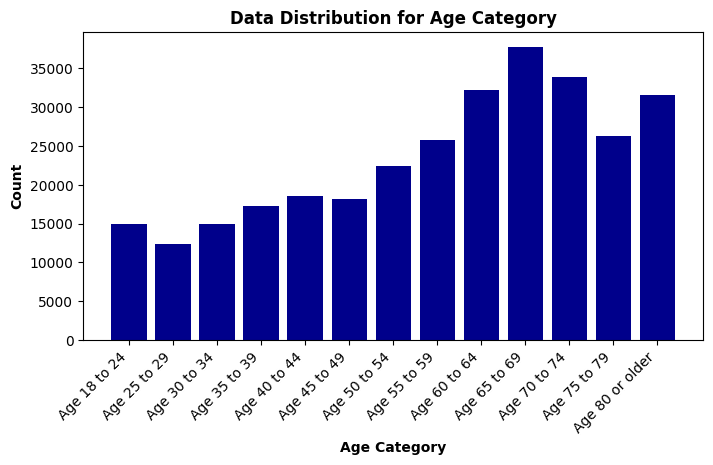

In [22]:
# Show data distribution for age category
dv.show_bar_graph(df=heart_disease_df, 
                  col_="AgeCategory", 
                  figure_size=(8,4),
                  title='Data Distribution for Age Category', 
                  x_label='Age Category', 
                  x_tick_rotation=45)

In [23]:
# NOTE: Performing a file checkpoint and spark restart actions due to the issue related to garbage collection
checkpoint_ctr = checkpoint_ctr + 1
heart_disease_df, spark = utils.data_checkpoint(spark, heart_disease_df, checkpoint_ctr)

__iv. Data Imputation for General Health__

For each combination of `Sex`, `WeightStatus`, and `GeneralHealth`, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the `GeneralHealth` will be imputed based on the subgroup.

*Example: Majority of underweight females fall into the 'Very Good' health. Hence, that specific general health category value will be used to replace the missing data for underweight females.*

In [24]:
print("Statistical analysis for general health based on sex and weight status")
genhealth_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "WeightStatus", "GeneralHealth")
genhealth_result.show()

Statistical analysis for general health based on sex and weight status


+------+--------------+-------------+-----+
|   Sex|  WeightStatus|GeneralHealth|count|
+------+--------------+-------------+-----+
|Female|Healthy Weight|    Very good|21378|
|Female|       Obesity|         Good|19282|
|Female|    Overweight|    Very good|21939|
|Female|   Underweight|    Very good| 1094|
|  Male|Healthy Weight|    Very good|12446|
|  Male|       Obesity|         Good|18208|
|  Male|    Overweight|    Very good|22873|
|  Male|   Underweight|         Good|  474|
+------+--------------+-------------+-----+



In [25]:
# Impute general health based on sex and weight status
print("Number of missing values in GeneralHealth before imputation: ", utils.count_missing_values(heart_disease_df, 'GeneralHealth'))
heart_disease_df = dp.impute_based_on_sws(heart_disease_df, genhealth_result, "GeneralHealth")
print("Number of missing values in GeneralHealth before imputation: ", utils.count_missing_values(heart_disease_df, 'GeneralHealth'))

Number of missing values in GeneralHealth before imputation:  648
Number of missing values in GeneralHealth before imputation:  0


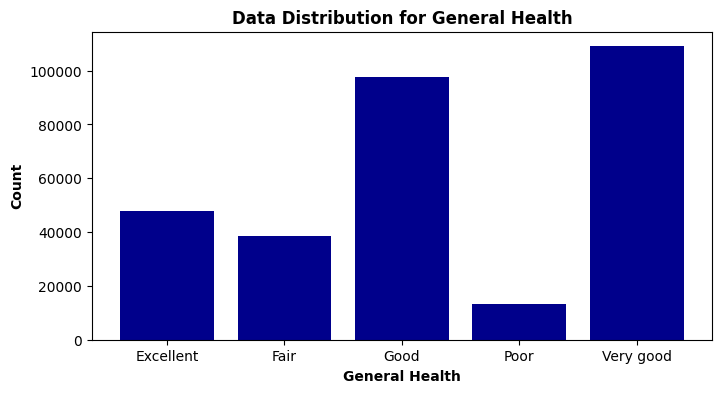

In [26]:
# Show data distribution of general health
dv.show_bar_graph(df=heart_disease_df, 
                  col_="GeneralHealth", 
                  figure_size=(8,4),
                  title='Data Distribution for General Health', 
                  x_label='General Health')

In [27]:
# NOTE: Performing a file checkpoint and spark restart actions due to the issue related to garbage collection
checkpoint_ctr = checkpoint_ctr + 1
heart_disease_df, spark = utils.data_checkpoint(spark, heart_disease_df, checkpoint_ctr)

__v. Data Imputation for Having Diabetes__

For each combination of `Sex`, `AgeCategory`, and `HadDiabetes`, the code identifies rows with the highest frequency by using a window function to find the maximum count within each subgroup. The missing data in the `HadDiabetes` will be imputed based on the subgroup. Based from the results from the table below, all missing values in `HadDiabetes` will be replaced by 'No'.

__NOTE:__ Same approach will be utilized for subsequent data imputations.

In [28]:
print("Statistical analysis for having diabetes based on sex and age category")
diabetes_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadDiabetes")
diabetes_result.show(30)

Statistical analysis for having diabetes based on sex and age category


+------+---------------+-----------+-----+
|   Sex|    AgeCategory|HadDiabetes|count|
+------+---------------+-----------+-----+
|Female|   Age 18 to 24|         No| 6159|
|Female|   Age 25 to 29|         No| 5464|
|Female|   Age 30 to 34|         No| 6869|
|Female|   Age 35 to 39|         No| 8022|
|Female|   Age 40 to 44|         No| 8698|
|Female|   Age 45 to 49|         No| 8452|
|Female|   Age 50 to 54|         No|10205|
|Female|   Age 55 to 59|         No|11421|
|Female|   Age 60 to 64|         No|14406|
|Female|   Age 65 to 69|         No|15816|
|Female|   Age 70 to 74|         No|14094|
|Female|   Age 75 to 79|         No|11459|
|Female|Age 80 or older|         No|16077|
|  Male|   Age 18 to 24|         No| 8438|
|  Male|   Age 25 to 29|         No| 6521|
|  Male|   Age 30 to 34|         No| 7338|
|  Male|   Age 35 to 39|         No| 8051|
|  Male|   Age 40 to 44|         No| 8225|
|  Male|   Age 45 to 49|         No| 7603|
|  Male|   Age 50 to 54|         No| 8877|
|  Male|   

In [29]:
# Impute all missing values with 'No' for all sex and age category
print("Number of missing values in HadDiabetes before imputation: ", utils.count_missing_values(heart_disease_df, 'HadDiabetes'))
heart_disease_df = heart_disease_df.fillna({'HadDiabetes': 'No'})
print("Number of missing values in HadDiabetes before imputation: ", utils.count_missing_values(heart_disease_df, 'HadDiabetes'))

Number of missing values in HadDiabetes before imputation:  397
Number of missing values in HadDiabetes before imputation:  0


In [30]:
# Show unique values under smoker status column
heart_disease_df.select("HadDiabetes").distinct().show(truncate=False)

+---------------------------------------+
|HadDiabetes                            |
+---------------------------------------+
|Yes, but only during pregnancy (female)|
|No                                     |
|Yes                                    |
|No, pre-diabetes or borderline diabetes|
+---------------------------------------+



Combine the following values in `HadDiabetes` column to simplify the feature
- No, pre-diabetes or borderline diabetes => No
- Yes, but only during pregnancy (female) => Yes

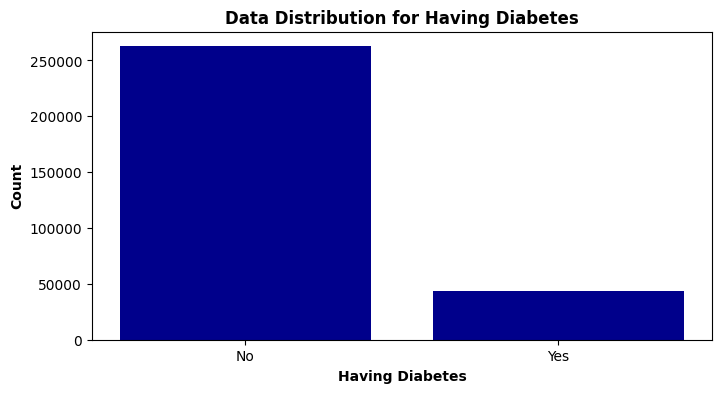

In [31]:
heart_disease_df = heart_disease_df.withColumn("HadDiabetes",
                    when((col("HadDiabetes") == "No, pre-diabetes or borderline diabetes"), "No")
                    .otherwise(when((col("HadDiabetes") == "Yes, but only during pregnancy (female)"), "Yes")
                    .otherwise(col("HadDiabetes"))))

# Show data distribution for having diabetes
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadDiabetes", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Diabetes', 
                  x_label='Having Diabetes')

__vi. Data Imputation for Having Stroke__

Based on the information provided in the table below, any missing values in the `HadStroke` column will be replaced with 'No.'

In [32]:
print("Statistical analysis for having stroke based on sex and age category")
stroke_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadStroke")
stroke_result.show(30)

Statistical analysis for having stroke based on sex and age category
+------+---------------+---------+-----+
|   Sex|    AgeCategory|HadStroke|count|
+------+---------------+---------+-----+
|Female|   Age 18 to 24|       No| 6327|
|Female|   Age 25 to 29|       No| 5701|
|Female|   Age 30 to 34|       No| 7366|
|Female|   Age 35 to 39|       No| 8661|
|Female|   Age 40 to 44|       No| 9497|
|Female|   Age 45 to 49|       No| 9353|
|Female|   Age 50 to 54|       No|11622|
|Female|   Age 55 to 59|       No|13233|
|Female|   Age 60 to 64|       No|16837|
|Female|   Age 65 to 69|       No|18800|
|Female|   Age 70 to 74|       No|16918|
|Female|   Age 75 to 79|       No|13543|
|Female|Age 80 or older|       No|17682|
|  Male|   Age 18 to 24|       No| 8594|
|  Male|   Age 25 to 29|       No| 6615|
|  Male|   Age 30 to 34|       No| 7475|
|  Male|   Age 35 to 39|       No| 8392|
|  Male|   Age 40 to 44|       No| 8740|
|  Male|   Age 45 to 49|       No| 8365|
|  Male|   Age 50 to 54|     

In [33]:
# Impute all missing values with 'No' for all sex and age category
print("Number of missing values in HadStroke before imputation: ", utils.count_missing_values(heart_disease_df, 'HadStroke'))
heart_disease_df = heart_disease_df.fillna({'HadStroke': 'No'})
print("Number of missing values in HadStroke before imputation: ", utils.count_missing_values(heart_disease_df, 'HadStroke'))


Number of missing values in HadStroke before imputation:  738
Number of missing values in HadStroke before imputation:  0


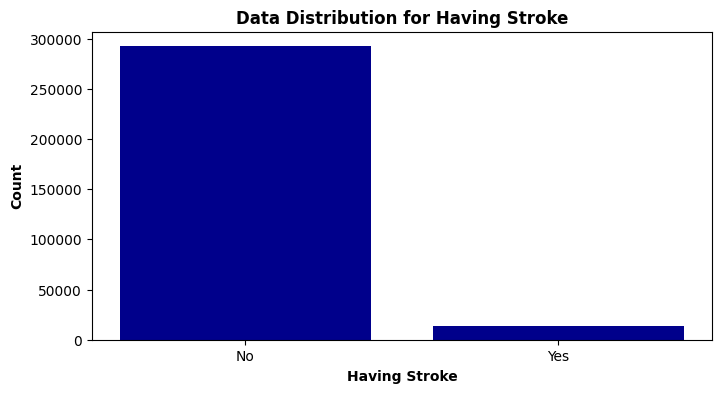

In [34]:
# Show data distribution for having stroke
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadStroke", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Stroke', 
                  x_label='Having Stroke')

__vii. Data Imputation for Having Asthma__

Based on the information provided in the table below, any missing values in the `HadAsthma` column will be replaced with 'No.'

In [35]:
print("Statistical analysis for having asthma based on sex and age category")
asthma_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadAsthma")
asthma_result.show(30)

Statistical analysis for having asthma based on sex and age category


+------+---------------+---------+-----+
|   Sex|    AgeCategory|HadAsthma|count|
+------+---------------+---------+-----+
|Female|   Age 18 to 24|       No| 4983|
|Female|   Age 25 to 29|       No| 4462|
|Female|   Age 30 to 34|       No| 5871|
|Female|   Age 35 to 39|       No| 7052|
|Female|   Age 40 to 44|       No| 7711|
|Female|   Age 45 to 49|       No| 7583|
|Female|   Age 50 to 54|       No| 9578|
|Female|   Age 55 to 59|       No|11136|
|Female|   Age 60 to 64|       No|14308|
|Female|   Age 65 to 69|       No|16277|
|Female|   Age 70 to 74|       No|15108|
|Female|   Age 75 to 79|       No|12441|
|Female|Age 80 or older|       No|17210|
|  Male|   Age 18 to 24|       No| 7039|
|  Male|   Age 25 to 29|       No| 5468|
|  Male|   Age 30 to 34|       No| 6312|
|  Male|   Age 35 to 39|       No| 7187|
|  Male|   Age 40 to 44|       No| 7580|
|  Male|   Age 45 to 49|       No| 7408|
|  Male|   Age 50 to 54|       No| 9100|
|  Male|   Age 55 to 59|       No|10507|
|  Male|   Age 6

In [36]:
# Impute all missing values with 'No' for all sex and age category
print("Number of missing values in HadAsthma before imputation: ", utils.count_missing_values(heart_disease_df, 'HadAsthma'))
heart_disease_df = heart_disease_df.fillna({'HadAsthma': 'No'})
print("Number of missing values in HadAsthma before imputation: ", utils.count_missing_values(heart_disease_df, 'HadAsthma'))


Number of missing values in HadAsthma before imputation:  997
Number of missing values in HadAsthma before imputation:  0


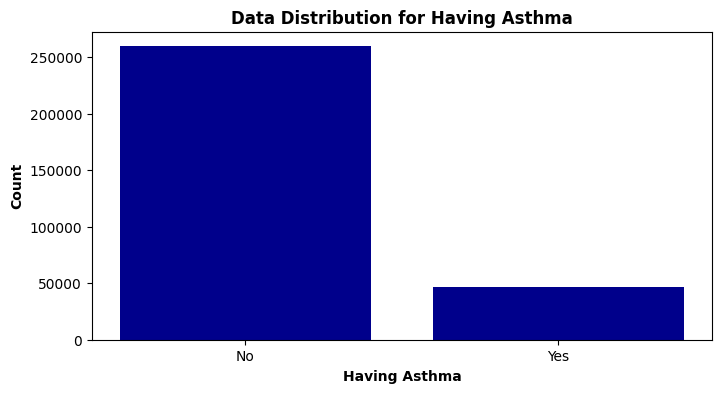

In [37]:
# Show data distribution for having ashtma
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadAsthma", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Asthma', 
                  x_label='Having Asthma')

__viii. Data Imputation for Having Skin Cancer__

Based on the information provided in the table below, any missing values in the `HadSkinCancer` column will be replaced with 'No.'

In [38]:
print("Statistical analysis for having skin cancer based on sex and age category")
skin_cancer_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadSkinCancer")
skin_cancer_result.show(30)

Statistical analysis for having skin cancer based on sex and age category


+------+---------------+-------------+-----+
|   Sex|    AgeCategory|HadSkinCancer|count|
+------+---------------+-------------+-----+
|Female|   Age 18 to 24|           No| 6311|
|Female|   Age 25 to 29|           No| 5699|
|Female|   Age 30 to 34|           No| 7329|
|Female|   Age 35 to 39|           No| 8582|
|Female|   Age 40 to 44|           No| 9364|
|Female|   Age 45 to 49|           No| 9144|
|Female|   Age 50 to 54|           No|11189|
|Female|   Age 55 to 59|           No|12489|
|Female|   Age 60 to 64|           No|15571|
|Female|   Age 65 to 69|           No|16978|
|Female|   Age 70 to 74|           No|14950|
|Female|   Age 75 to 79|           No|11656|
|Female|Age 80 or older|           No|15360|
|  Male|   Age 18 to 24|           No| 8546|
|  Male|   Age 25 to 29|           No| 6608|
|  Male|   Age 30 to 34|           No| 7483|
|  Male|   Age 35 to 39|           No| 8354|
|  Male|   Age 40 to 44|           No| 8671|
|  Male|   Age 45 to 49|           No| 8247|
|  Male|  

In [39]:
# Impute all missing values with 'No' for all sex and age category
print("Number of missing values in HadSkinCancer before imputation: ", utils.count_missing_values(heart_disease_df, 'HadSkinCancer'))
heart_disease_df = heart_disease_df.fillna({'HadSkinCancer': 'No'})
print("Number of missing values in HadSkinCancer before imputation: ", utils.count_missing_values(heart_disease_df, 'HadSkinCancer'))

Number of missing values in HadSkinCancer before imputation:  2250
Number of missing values in HadSkinCancer before imputation:  0


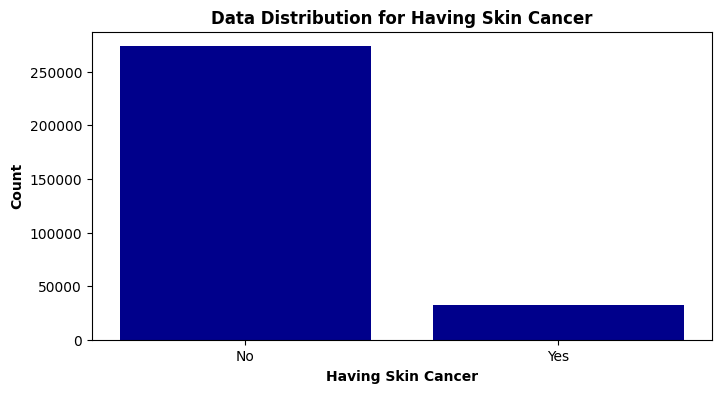

In [40]:
# Show data distribution for having skin cancer
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadSkinCancer", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Skin Cancer', 
                  x_label='Having Skin Cancer')

__xv. Data Imputation for Having Kidney Disease__

Based on the information provided in the table below, any missing values in the `HadKidneyDisease` column will be replaced with 'No.'

In [41]:
print("Statistical analysis for having kidney disease based on sex and age category")
kidney_disease_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "HadKidneyDisease")
kidney_disease_result.show(30)

Statistical analysis for having kidney disease based on sex and age category


+------+---------------+----------------+-----+
|   Sex|    AgeCategory|HadKidneyDisease|count|
+------+---------------+----------------+-----+
|Female|   Age 18 to 24|              No| 6287|
|Female|   Age 25 to 29|              No| 5675|
|Female|   Age 30 to 34|              No| 7303|
|Female|   Age 35 to 39|              No| 8609|
|Female|   Age 40 to 44|              No| 9463|
|Female|   Age 45 to 49|              No| 9319|
|Female|   Age 50 to 54|              No|11595|
|Female|   Age 55 to 59|              No|13124|
|Female|   Age 60 to 64|              No|16717|
|Female|   Age 65 to 69|              No|18578|
|Female|   Age 70 to 74|              No|16506|
|Female|   Age 75 to 79|              No|13318|
|Female|Age 80 or older|              No|17667|
|  Male|   Age 18 to 24|              No| 8571|
|  Male|   Age 25 to 29|              No| 6614|
|  Male|   Age 30 to 34|              No| 7476|
|  Male|   Age 35 to 39|              No| 8376|
|  Male|   Age 40 to 44|              No

In [42]:
# Impute all missing values with 'No' for all sex and age category
print("Number of missing values in HadKidneyDisease before imputation: ", utils.count_missing_values(heart_disease_df, 'HadKidneyDisease'))
heart_disease_df = heart_disease_df.fillna({'HadKidneyDisease': 'No'})
print("Number of missing values in HadKidneyDisease before imputation: ", utils.count_missing_values(heart_disease_df, 'HadKidneyDisease'))

Number of missing values in HadKidneyDisease before imputation: 

 1068
Number of missing values in HadKidneyDisease before imputation:  0


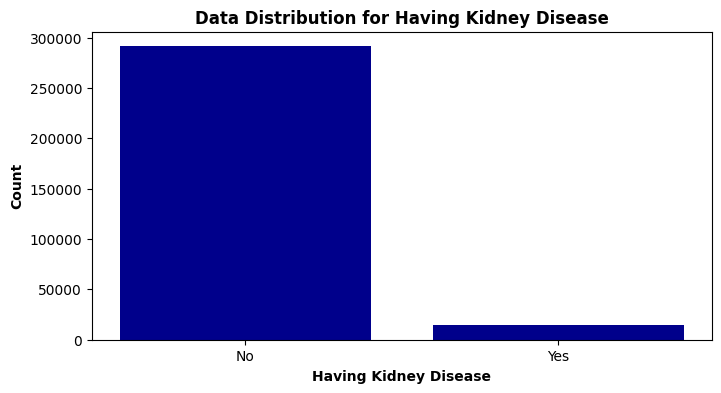

In [43]:
# Show data distribution for having kidney disease
dv.show_bar_graph(df=heart_disease_df, 
                  col_="HadKidneyDisease", 
                  figure_size=(8,4),
                  title='Data Distribution for Having Kidney Disease', 
                  x_label='Having Kidney Disease')

In [44]:
# NOTE: Performing a file checkpoint and spark restart actions due to the issue related to garbage collection
checkpoint_ctr = checkpoint_ctr + 1
heart_disease_df, spark = utils.data_checkpoint(spark, heart_disease_df, checkpoint_ctr)

__x. Data Imputation for Smoker and Alcohol Drinker__

Based from the results below, individuals aged 75 and above who are male are mostly former smokers. Other groups indicate that there is no history of smoking.

In [45]:
print("Statistical analysis for smoker status based on sex and age category")
smoker_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "SmokerStatus")
smoker_result.show(30)

Statistical analysis for smoker status based on sex and age category
+------+---------------+-------------+-----+
|   Sex|    AgeCategory| SmokerStatus|count|
+------+---------------+-------------+-----+
|Female|   Age 18 to 24| Never smoked| 5203|
|Female|   Age 25 to 29| Never smoked| 4007|
|Female|   Age 30 to 34| Never smoked| 4599|
|Female|   Age 35 to 39| Never smoked| 5085|
|Female|   Age 40 to 44| Never smoked| 5003|
|Female|   Age 45 to 49| Never smoked| 5141|
|Female|   Age 50 to 54| Never smoked| 6618|
|Female|   Age 55 to 59| Never smoked| 7181|
|Female|   Age 60 to 64| Never smoked| 8840|
|Female|   Age 65 to 69| Never smoked|10436|
|Female|   Age 70 to 74| Never smoked| 9920|
|Female|   Age 75 to 79| Never smoked| 7779|
|Female|Age 80 or older| Never smoked|11360|
|  Male|   Age 18 to 24| Never smoked| 6733|
|  Male|   Age 25 to 29| Never smoked| 4365|
|  Male|   Age 30 to 34| Never smoked| 4207|
|  Male|   Age 35 to 39| Never smoked| 4237|
|  Male|   Age 40 to 44| Never 

In [46]:
# Impute smoking status based on sex and age category
print("Number of missing values in SmokerStatus before imputation: ", utils.count_missing_values(heart_disease_df, 'SmokerStatus'))
heart_disease_df = dp.impute_smoking_status(heart_disease_df)
print("Number of missing values in SmokerStatus before imputation: ", utils.count_missing_values(heart_disease_df, 'SmokerStatus'))

Number of missing values in SmokerStatus before imputation:  18895
Number of missing values in SmokerStatus before imputation:  0


In [47]:
# Show unique values under smoker status column
heart_disease_df.select("SmokerStatus").distinct().show(truncate=False)

+-------------------------------------+
|SmokerStatus                         |
+-------------------------------------+
|Current smoker - now smokes every day|
|Never smoker                         |
|Never smoked                         |
|Current smoker - now smokes some days|
|Former smoker                        |
+-------------------------------------+



Combine the following values in `SmokerStatus` column to simplify the feature, resulting to the following values: 'Never smoked', 'Former smoker' and 'Current smoker'.
- Current smoker - now smokes every day => Current smoker
- Current smoker - now smokes some days => Current smoker
- Never smoker => Never smoked

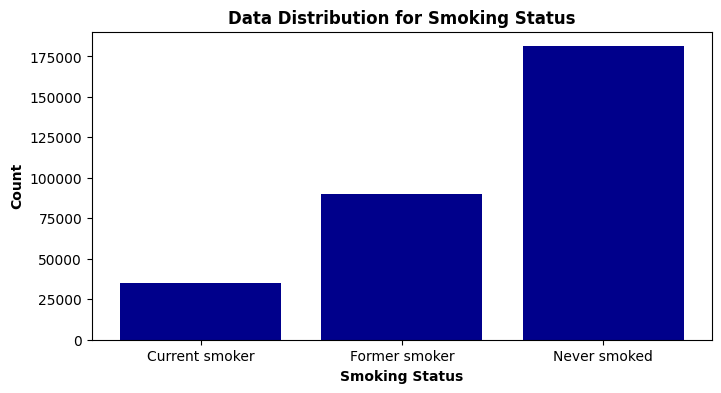

In [48]:
heart_disease_df = heart_disease_df.withColumn("SmokerStatus",
    when(((col("SmokerStatus") == "Current smoker - now smokes every day") | (col("SmokerStatus") == "Current smoker - now smokes some days")), "Current smoker")
    .otherwise(when((col("SmokerStatus") == "Never smoker"), "Never smoked")
    .otherwise(col("SmokerStatus"))))

# Show data distribution for smoking status
dv.show_bar_graph(df=heart_disease_df, 
                  col_="SmokerStatus", 
                  figure_size=(8,4),
                  title='Data Distribution for Smoking Status', 
                  x_label='Smoking Status')

For the `AlcoholDrinkers` feature, the result below indicates that females aged 65 and older and males aged 80 and older predominantly do not consume alcohol. The other groups within this category are primarily characterized as regular drinkers.

In [49]:
print("Statistical analysis for alcohol drinker based on sex and age category")
alcohol_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "AlcoholDrinkers")
alcohol_result.show(30)

Statistical analysis for alcohol drinker based on sex and age category


+------+---------------+---------------+-----+
|   Sex|    AgeCategory|AlcoholDrinkers|count|
+------+---------------+---------------+-----+
|Female|   Age 18 to 24|            Yes| 3398|
|Female|   Age 25 to 29|            Yes| 3383|
|Female|   Age 30 to 34|            Yes| 4143|
|Female|   Age 35 to 39|            Yes| 4899|
|Female|   Age 40 to 44|            Yes| 5352|
|Female|   Age 45 to 49|            Yes| 5123|
|Female|   Age 50 to 54|            Yes| 6307|
|Female|   Age 55 to 59|            Yes| 6807|
|Female|   Age 60 to 64|            Yes| 8358|
|Female|   Age 65 to 69|             No| 9418|
|Female|   Age 70 to 74|             No| 9198|
|Female|   Age 75 to 79|             No| 7982|
|Female|Age 80 or older|             No|11616|
|  Male|   Age 18 to 24|            Yes| 4644|
|  Male|   Age 25 to 29|            Yes| 4440|
|  Male|   Age 30 to 34|            Yes| 4854|
|  Male|   Age 35 to 39|            Yes| 5338|
|  Male|   Age 40 to 44|            Yes| 5357|
|  Male|   Ag

In [50]:
# Impute alcohol drinker based on sex and age category
print("Number of missing values in AlcoholDrinkers before imputation: ", utils.count_missing_values(heart_disease_df, 'AlcoholDrinkers'))
heart_disease_df = dp.impute_alcohol_drinker(heart_disease_df)
print("Number of missing values in AlcoholDrinkers before imputation: ", utils.count_missing_values(heart_disease_df, 'AlcoholDrinkers'))


Number of missing values in AlcoholDrinkers before imputation:  26074


Number of missing values in AlcoholDrinkers before imputation:  0


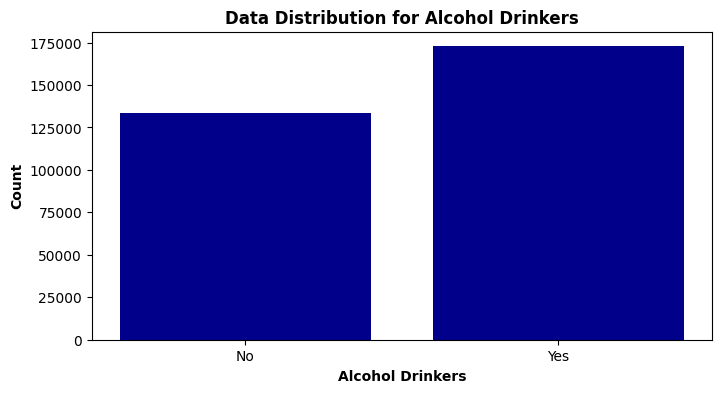

In [51]:
# Show data distribution for alcohol drinkers
dv.show_bar_graph(df=heart_disease_df, 
                  col_="AlcoholDrinkers", 
                  figure_size=(8,4),
                  title='Data Distribution for Alcohol Drinkers', 
                  x_label='Alcohol Drinkers')

__xi. Data Imputation for Physically Active__

Based on the information provided in the table below, any missing values in the `PhysicalActivities` column will be replaced with 'Yes'

In [52]:
print("Statistical analysis for physically active group based on sex and age category")
phyactive_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "PhysicalActivities")
phyactive_result.show(30)

Statistical analysis for physically active group based on sex and age category
+------+---------------+------------------+-----+
|   Sex|    AgeCategory|PhysicalActivities|count|
+------+---------------+------------------+-----+
|Female|   Age 18 to 24|               Yes| 5448|
|Female|   Age 25 to 29|               Yes| 4890|
|Female|   Age 30 to 34|               Yes| 6223|
|Female|   Age 35 to 39|               Yes| 7396|
|Female|   Age 40 to 44|               Yes| 7891|
|Female|   Age 45 to 49|               Yes| 7536|
|Female|   Age 50 to 54|               Yes| 9165|
|Female|   Age 55 to 59|               Yes|10281|
|Female|   Age 60 to 64|               Yes|13115|
|Female|   Age 65 to 69|               Yes|14578|
|Female|   Age 70 to 74|               Yes|12953|
|Female|   Age 75 to 79|               Yes|10023|
|Female|Age 80 or older|               Yes|12235|
|  Male|   Age 18 to 24|               Yes| 7589|
|  Male|   Age 25 to 29|               Yes| 5803|
|  Male|   Age 30 to 

In [53]:
# Imput all missing values with 'No' for all sex and age category
print("Number of missing values in AlcoholDrinkers before imputation: ", utils.count_missing_values(heart_disease_df, 'PhysicalActivities'))
heart_disease_df = heart_disease_df.fillna({'PhysicalActivities': 'Yes'})
print("Number of missing values in AlcoholDrinkers before imputation: ", utils.count_missing_values(heart_disease_df, 'PhysicalActivities'))


Number of missing values in AlcoholDrinkers before imputation:  649
Number of missing values in AlcoholDrinkers before imputation:  0


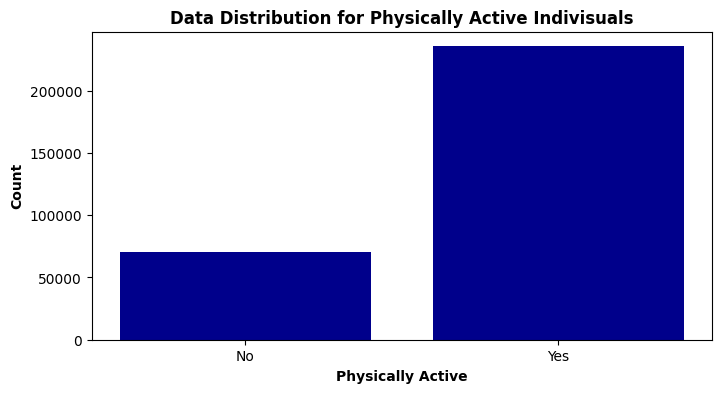

In [54]:
# Show data distribution for physically active inidividuals
dv.show_bar_graph(df=heart_disease_df, 
                  col_="PhysicalActivities", 
                  figure_size=(8,4),
                  title='Data Distribution for Physically Active Indivisuals', 
                  x_label='Physically Active')

__xii. Data Imputation for Difficulty Walking__

Based on the information provided in the table below, any missing values in the `DifficultyWalking` column will be replaced with 'No'

In [55]:
print("Statistical analysis for difficulty of walking based on sex and age category")
diffwalking_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "DifficultyWalking")
diffwalking_result.show(30)

Statistical analysis for difficulty of walking based on sex and age category


+------+---------------+-----------------+-----+
|   Sex|    AgeCategory|DifficultyWalking|count|
+------+---------------+-----------------+-----+
|Female|   Age 18 to 24|               No| 5867|
|Female|   Age 25 to 29|               No| 5302|
|Female|   Age 30 to 34|               No| 6802|
|Female|   Age 35 to 39|               No| 7953|
|Female|   Age 40 to 44|               No| 8584|
|Female|   Age 45 to 49|               No| 8225|
|Female|   Age 50 to 54|               No| 9878|
|Female|   Age 55 to 59|               No|10839|
|Female|   Age 60 to 64|               No|13673|
|Female|   Age 65 to 69|               No|15204|
|Female|   Age 70 to 74|               No|13304|
|Female|   Age 75 to 79|               No|10138|
|Female|Age 80 or older|               No|11991|
|  Male|   Age 18 to 24|               No| 8131|
|  Male|   Age 25 to 29|               No| 6261|
|  Male|   Age 30 to 34|               No| 7019|
|  Male|   Age 35 to 39|               No| 7854|
|  Male|   Age 40 to

In [56]:
# Imput all missing values with 'No' for all sex and age category
print("Number of missing values in DifficultyWalking before imputation: ", utils.count_missing_values(heart_disease_df, 'DifficultyWalking'))
heart_disease_df = heart_disease_df.fillna({'DifficultyWalking': 'No'})
print("Number of missing values in DifficultyWalking before imputation: ", utils.count_missing_values(heart_disease_df, 'DifficultyWalking'))

Number of missing values in DifficultyWalking before imputation:  11359
Number of missing values in DifficultyWalking before imputation:  0


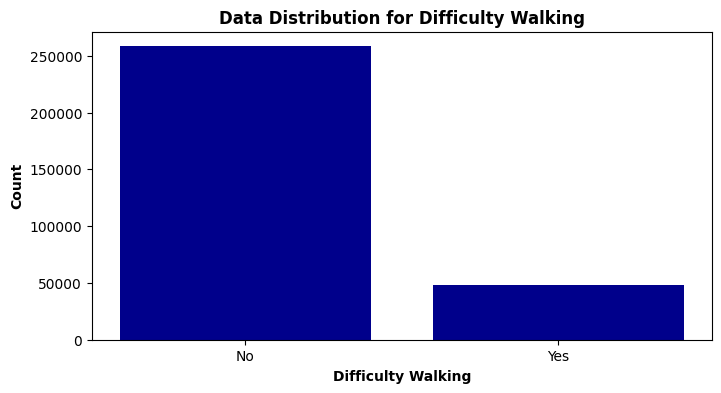

In [57]:
# Show data distribution for difficulty walking
dv.show_bar_graph(df=heart_disease_df, 
                  col_="DifficultyWalking", 
                  figure_size=(8,4),
                  title='Data Distribution for Difficulty Walking', 
                  x_label='Difficulty Walking')

__xiii. Data Imputation for Physical and Mental Health Days__

Based on the information provided in the table below, any missing values in the `PhysicalHealthDays` column will be replaced with '0'

In [58]:
print("Statistical analysis for physical health days based on sex and age category")
phyhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "PhysicalHealthDays")
phyhealthdays_result.show(30)

Statistical analysis for physical health days based on sex and age category


+------+---------------+------------------+-----+
|   Sex|    AgeCategory|PhysicalHealthDays|count|
+------+---------------+------------------+-----+
|Female|   Age 18 to 24|               0.0| 3249|
|Female|   Age 25 to 29|               0.0| 3135|
|Female|   Age 30 to 34|               0.0| 3968|
|Female|   Age 35 to 39|               0.0| 4847|
|Female|   Age 40 to 44|               0.0| 5327|
|Female|   Age 45 to 49|               0.0| 5203|
|Female|   Age 50 to 54|               0.0| 6534|
|Female|   Age 55 to 59|               0.0| 7507|
|Female|   Age 60 to 64|               0.0| 9682|
|Female|   Age 65 to 69|               0.0|11283|
|Female|   Age 70 to 74|               0.0|10504|
|Female|   Age 75 to 79|               0.0| 8462|
|Female|Age 80 or older|               0.0|11425|
|  Male|   Age 18 to 24|               0.0| 5225|
|  Male|   Age 25 to 29|               0.0| 4120|
|  Male|   Age 30 to 34|               0.0| 4665|
|  Male|   Age 35 to 39|               0.0| 5329|


In [59]:
# Impute all missing values with 'No' for all sex and age category
print("Number of missing values in PhysicalHealthDays before imputation: ", utils.count_missing_values(heart_disease_df, 'PhysicalHealthDays'))
heart_disease_df = heart_disease_df.fillna({'PhysicalHealthDays': 0})
print("Number of missing values in PhysicalHealthDays before imputation: ", utils.count_missing_values(heart_disease_df, 'PhysicalHealthDays'))


Number of missing values in PhysicalHealthDays before imputation:  6618
Number of missing values in PhysicalHealthDays before imputation:  0


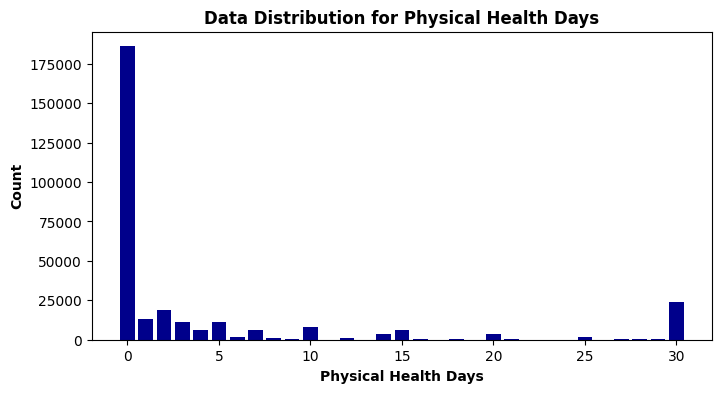

In [60]:
# Show data distribution for physical health days
dv.show_bar_graph(df=heart_disease_df, 
                  col_="PhysicalHealthDays", 
                  figure_size=(8,4),
                  title='Data Distribution for Physical Health Days', 
                  x_label='Physical Health Days')

Calculate the ratio of records where the value in the `PhysicalHealthDays` column is equal to 0. Need to note that zero (0) has a ratio of 60.76% out of 30 values in the dataset.

In [61]:
zero_val_ratio = heart_disease_df.filter(col("PhysicalHealthDays") == 0).count() / heart_disease_df.count()
print(f"{zero_val_ratio*100}% of the records comprises of zero (0) values.")

60.76278966437647% of the records comprises of zero (0) values.


Based on the information provided in the table below, any missing values in the `MentalHealthDays` column will be replaced with '0'

In [62]:
print("Statistical analysis for mental health days based on sex and age category")
menhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "MentalHealthDays")
menhealthdays_result.show(30)

Statistical analysis for mental health days based on sex and age category


+------+---------------+----------------+-----+
|   Sex|    AgeCategory|MentalHealthDays|count|
+------+---------------+----------------+-----+
|Female|   Age 18 to 24|             0.0| 1204|
|Female|   Age 25 to 29|             0.0| 1442|
|Female|   Age 30 to 34|             0.0| 2219|
|Female|   Age 35 to 39|             0.0| 3024|
|Female|   Age 40 to 44|             0.0| 3753|
|Female|   Age 45 to 49|             0.0| 4093|
|Female|   Age 50 to 54|             0.0| 5590|
|Female|   Age 55 to 59|             0.0| 6978|
|Female|   Age 60 to 64|             0.0| 9977|
|Female|   Age 65 to 69|             0.0|12133|
|Female|   Age 70 to 74|             0.0|11805|
|Female|   Age 75 to 79|             0.0|10108|
|Female|Age 80 or older|             0.0|14384|
|  Male|   Age 18 to 24|             0.0| 3243|
|  Male|   Age 25 to 29|             0.0| 2662|
|  Male|   Age 30 to 34|             0.0| 3294|
|  Male|   Age 35 to 39|             0.0| 4244|
|  Male|   Age 40 to 44|             0.0

In [63]:
# Impute all missing values with 'No' for all sex and age category
print("Number of missing values in MentalHealthDays before imputation: ", utils.count_missing_values(heart_disease_df, 'MentalHealthDays'))
heart_disease_df = heart_disease_df.fillna({'MentalHealthDays': 0})
print("Number of missing values in MentalHealthDays before imputation: ", utils.count_missing_values(heart_disease_df, 'MentalHealthDays'))

Number of missing values in MentalHealthDays before imputation:  5496
Number of missing values in MentalHealthDays before imputation:  0


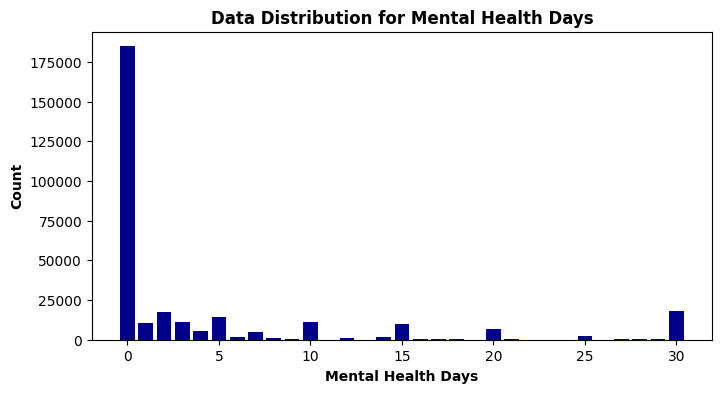

In [64]:
# Show data distribution for mental health days
dv.show_bar_graph(df=heart_disease_df, 
                  col_="MentalHealthDays", 
                  figure_size=(8,4),
                  title='Data Distribution for Mental Health Days', 
                  x_label='Mental Health Days')

Calculate the ratio of records where the value in the `MentalHealthDays` column is equal to 0. Need to note that zero (0) has a ratio of 60.4% out of 30 values in the dataset.

In [65]:
zero_val_ratio = heart_disease_df.filter(col("MentalHealthDays") == 0).count() / heart_disease_df.count()
print(f"{zero_val_ratio*100}% of the records comprises of zero (0) values.")

60.396553920944044% of the records comprises of zero (0) values.


__Decision to Drop Features:__ If one category represents a significant portion of the data, it may not contribute much information to the model and can potentially lead to overfitting or bias. Also this feature does not add any value to the predictive task. Hence, we'll be dropping `PhysicalHealthDays` and `MentalHealthDays` from the features since zero (0) has more than 60% ratio out of 30 values.

In [66]:
heart_disease_df = heart_disease_df.drop(*['MentalHealthDays', 'PhysicalHealthDays'])
print(f"Columns: {heart_disease_df.columns}")

Columns: ['Sex', 'GeneralHealth', 'PhysicalActivities', 'SleepHours', 'HadHeartAttack', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadKidneyDisease', 'HadDiabetes', 'DifficultyWalking', 'SmokerStatus', 'RaceEthnicityCategory', 'AgeCategory', 'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'WeightStatus']


__xiv. Data Imputation for Sleeping Hours__

Based from the results below, individuals aged 65 years and older have an average sleep duration of 8 hours, while other age groups typically sleep for seven hours on average.

In [67]:
print("Statistical analysis for sleep hours based on sex and age category")
menhealthdays_result = dp.get_statistical_analysis(heart_disease_df, "Sex", "AgeCategory", "SleepHours")
menhealthdays_result.show(30)

Statistical analysis for sleep hours based on sex and age category
+------+---------------+----------+-----+
|   Sex|    AgeCategory|SleepHours|count|
+------+---------------+----------+-----+
|Female|   Age 18 to 24|       7.0| 1902|
|Female|   Age 25 to 29|       7.0| 1817|
|Female|   Age 30 to 34|       7.0| 2313|
|Female|   Age 35 to 39|       7.0| 2968|
|Female|   Age 40 to 44|       7.0| 3241|
|Female|   Age 45 to 49|       7.0| 3198|
|Female|   Age 50 to 54|       7.0| 3852|
|Female|   Age 55 to 59|       7.0| 4438|
|Female|   Age 60 to 64|       7.0| 5584|
|Female|   Age 65 to 69|       8.0| 6106|
|Female|   Age 70 to 74|       8.0| 5838|
|Female|   Age 75 to 79|       8.0| 4999|
|Female|Age 80 or older|       8.0| 6846|
|  Male|   Age 18 to 24|       7.0| 2803|
|  Male|   Age 25 to 29|       7.0| 2343|
|  Male|   Age 30 to 34|       7.0| 2553|
|  Male|   Age 35 to 39|       7.0| 2921|
|  Male|   Age 40 to 44|       7.0| 3116|
|  Male|   Age 45 to 49|       7.0| 2962|
|  Male| 

In [68]:
# Impute sleep hours based on sex and weight status
print("Number of missing values in SleepHours before imputation: ", utils.count_missing_values(heart_disease_df, 'SleepHours'))
heart_disease_df = dp.impute_sleep_hours(heart_disease_df)
print("Number of missing values in SleepHours before imputation: ", utils.count_missing_values(heart_disease_df, 'SleepHours'))

Number of missing values in SleepHours before imputation:  2959
Number of missing values in SleepHours before imputation:  0


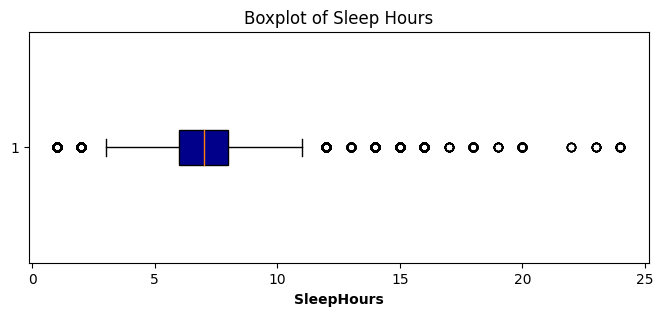

In [69]:
# Create a boxplot using Matplotlib
sleephours_data = heart_disease_df.select("SleepHours").rdd.flatMap(lambda x: x).collect()
dv.show_boxplot_graph(data=sleephours_data, figure_size=(8,3), title='Boxplot of Sleep Hours', x_label='SleepHours')

We will remove any outliers present in the `SleepHours` to enhance the accuracy and reliability of our analysis. Hence, the range of sleeping hours spans from a minimum of 3 hours to a maximum of 11 hours.

In [70]:
heart_disease_df = heart_disease_df.filter((col("SleepHours") >= 3) & (col("SleepHours") <= 11))
heart_disease_df.select(min(col("SleepHours")).alias("Min Sleep Hours"), max(col("SleepHours")).alias("Max Sleep Hours")).show()

+---------------+---------------+
|Min Sleep Hours|Max Sleep Hours|
+---------------+---------------+
|            3.0|           11.0|
+---------------+---------------+



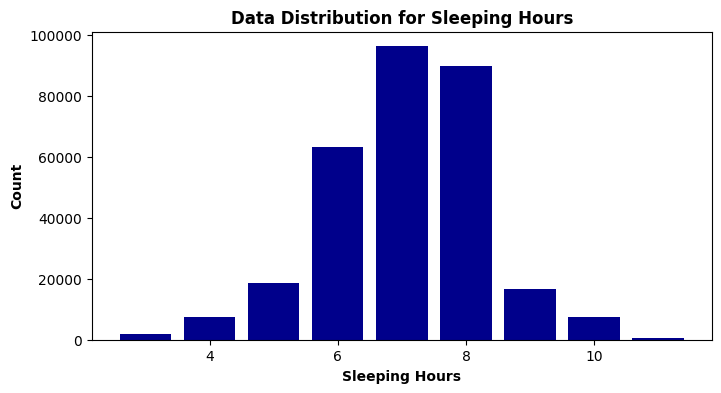

In [71]:
# Show data distribution for mental health days
dv.show_bar_graph(df=heart_disease_df, 
                  col_="SleepHours", 
                  figure_size=(8,4),
                  title='Data Distribution for Sleeping Hours', 
                  x_label='Sleeping Hours')

In [72]:
# NOTE: Performing a file checkpoint and spark restart actions due to the issue related to garbage collection
checkpoint_ctr = checkpoint_ctr + 1
heart_disease_df, spark = utils.data_checkpoint(spark, heart_disease_df, checkpoint_ctr)

Drop any remaining duplicate records resulting from data imputation

In [73]:
print(f"Record count before dropping duplicates => {heart_disease_df.count()}")
heart_disease_df = heart_disease_df.dropDuplicates()
print(f"Record count after dropping duplicates  => {heart_disease_df.count()}")

Record count before dropping duplicates => 301908
Record count after dropping duplicates  => 274367


__Pearson Correlation__

The analysis reveals a strong correlation of 0.86 between WeightStatus and BMI, and a moderately correlated relationship of 0.48 with HeightInMeters. Since HeightInMeters and WeightStatus contribute to BMI calculation, these features can be safely dropped from the dataset.

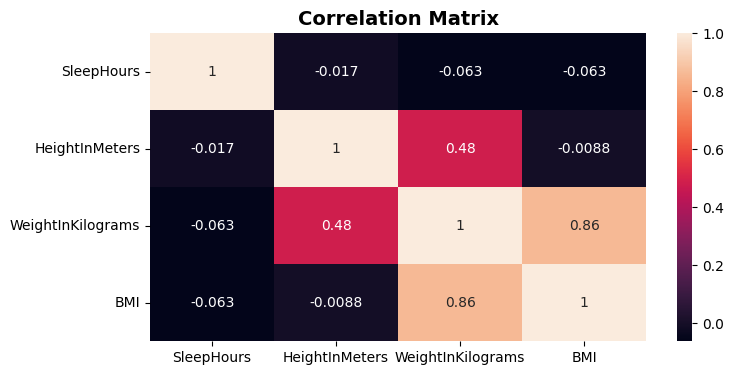

In [74]:
# Compute and plot the correlation matrix
heart_disease_pd = heart_disease_df.toPandas()
numeric_features_df = heart_disease_pd.select_dtypes(include=['number'])

plt.figure(figsize=(8,4))
sns.heatmap(numeric_features_df.corr(), annot=True)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.show()

Remove redundant features, i.e. `WeightStatus`, `HeightInMeters`, `WeightInKilograms`, as they are solely utilized for BMI calculation and imputation of the person's age category and general health. Furthermore, given that we restrict the `RaceEthnicityCategory` to 'White only, Non-Hispanic', we will exclude this feature from consideration since it contains only a one value.

In [75]:
heart_disease_df = heart_disease_df.drop(*['WeightStatus', 'HeightInMeters', 'WeightInKilograms', 'RaceEthnicityCategory'])
print(f"Columns: {heart_disease_df.columns}")

Columns: ['Sex', 'GeneralHealth', 'PhysicalActivities', 'SleepHours', 'HadHeartAttack', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadKidneyDisease', 'HadDiabetes', 'DifficultyWalking', 'SmokerStatus', 'AgeCategory', 'BMI', 'AlcoholDrinkers']


### __Feature Engineering__

There are 4 important transfer/estimators from pyspark.ml library that are necessary to apply in the dataset before building a model.
- __StringIndexer:__ converts string categorical values into numerical indices
- __OneHotEncoderEstimator:__ converts categorical indices into a sparse vector of binary values
- __VectorAssembler:__ Combines multiple feature columns, including one-hot encoded vectors, into a single feature vector
- __StandardScaler:__ scales and centers numerical features, transforming them to have a mean of 0 and a standard deviation of 1

##### __Encoding Categorical Features__

Categorical features represent variables with a limited set of values. Machine learning algorithms, especially those relying on mathematical equations, require numerical input. Hence, converting categorical features into numerical format is crucial for preparing data for machine learning models.

__*For Target Variable:*__ Transform the target variable into binary values where the value is 0 (representing No) or 1 (representing Yes).

In [76]:
# For target feature with binary values
indexer = StringIndexer(inputCol="HadHeartAttack", outputCol="label", stringOrderType="alphabetAsc")
heart_disease_df = indexer.fit(heart_disease_df).transform(heart_disease_df)

# # Drop the original columns, replacing by the encoded values
heart_disease_df = heart_disease_df.drop(*["HadHeartAttack"])

heart_disease_df.show(5)

+------+-------------+------------------+----------+---------+---------+-------------+----------------+-----------+-----------------+-------------+---------------+------------------+---------------+-----+
|   Sex|GeneralHealth|PhysicalActivities|SleepHours|HadStroke|HadAsthma|HadSkinCancer|HadKidneyDisease|HadDiabetes|DifficultyWalking| SmokerStatus|    AgeCategory|               BMI|AlcoholDrinkers|label|
+------+-------------+------------------+----------+---------+---------+-------------+----------------+-----------+-----------------+-------------+---------------+------------------+---------------+-----+
|Female|    Excellent|               Yes|       9.0|       No|       No|           No|              No|         No|               No|Former smoker|Age 80 or older|             29.53|            Yes|  0.0|
|  Male|         Poor|               Yes|       7.0|       No|       No|           No|             Yes|        Yes|              Yes|Former smoker|   Age 70 to 74|             26.6

__*For Input Variables:*__ Convert input variables to one-hot encoding using `StringIndexer` and `OneHotEncoder`.

In [77]:
categorical_features = [type[0] for type in heart_disease_df.dtypes if type[1] == 'string']
categorical_features_df = heart_disease_df.select(categorical_features)

# Perform one-hot encoding to categorical features
heart_disease_df = dp.convert_one_hot_encoding(heart_disease_df, columns=categorical_features_df.columns)

# Drop the original columns, replacing by the encoded values
heart_disease_df = heart_disease_df.drop(*categorical_features_df.columns)

heart_disease_df.show(5)

+----------+------------------+-----+-------------+-----------------+----------------------+-------------+-------------+-----------------+--------------------+---------------+---------------------+----------------+---------------+-------------------+
|SleepHours|               BMI|label|      Sex_vec|GeneralHealth_vec|PhysicalActivities_vec|HadStroke_vec|HadAsthma_vec|HadSkinCancer_vec|HadKidneyDisease_vec|HadDiabetes_vec|DifficultyWalking_vec|SmokerStatus_vec|AgeCategory_vec|AlcoholDrinkers_vec|
+----------+------------------+-----+-------------+-----------------+----------------------+-------------+-------------+-----------------+--------------------+---------------+---------------------+----------------+---------------+-------------------+
|       9.0|             29.53|  0.0|(1,[0],[1.0])|    (4,[0],[1.0])|             (1,[],[])|(1,[0],[1.0])|(1,[0],[1.0])|    (1,[0],[1.0])|       (1,[0],[1.0])|  (1,[0],[1.0])|        (1,[0],[1.0])|   (2,[1],[1.0])|     (12,[],[])|          (1,[],[

##### __Performing Vector Assembler__

VectorAssembler is used to combine multiple feature columns, including one-hot encoded vectors, into a single feature vector.

In [78]:
# Create vector assembler
vector_assembler = VectorAssembler(inputCols=heart_disease_df.drop("label").columns, outputCol='vec_features')
pipeline = Pipeline(stages=[vector_assembler])

heart_disease_df = pipeline.fit(heart_disease_df).transform(heart_disease_df)

# Define a UDF to convert the vector column to DenseVector
to_dense_vector_udf = udf(lambda v: DenseVector(v.toArray()), VectorUDT())

# Apply the UDF to the "vec_features" column
heart_disease_df = heart_disease_df.withColumn("vec_features", to_dense_vector_udf("vec_features"))

heart_disease_new_df = heart_disease_df.select("vec_features", "label")
heart_disease_new_df.show(n=5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------+-----+
|vec_features                                                                                                                        |label|
+------------------------------------------------------------------------------------------------------------------------------------+-----+
|[9.0,29.53,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]             |0.0  |
|[7.0,26.69,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0]             |0.0  |
|[8.0,28.632748390354752,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]|0.0  |
|[6.0,23.75,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0]             |0.0  |
|[7.0,33.28,1

##### __Splitting Dataset to Train and Test__

There are a total of 274,367 records. Divide the data into training and testing sets, with 20% reserved for testing.

In [79]:
train_data, test_data = heart_disease_new_df.randomSplit([0.8, 0.2], seed=42)

print(f"Shape of the train dataset: ({train_data.count()}, {len(train_data.columns)})")
print(f"Shape of the test dataset: ({test_data.count()}, {len(test_data.columns)})")

Shape of the train dataset: (219956, 2)
Shape of the test dataset: (54411, 2)


##### __Scaling Dataset__

Scaling the dataset is important for machine learning models as it ensures that features with different scales contribute equally. Standardization, a scaling technique, enhances model performance by transforming features to have zero mean and unit variance, promoting stable and efficient learning. 

In [80]:
# Standardize the data
standardscaler = StandardScaler(inputCol="vec_features", outputCol='scaled_features', withMean=True, withStd=True)

# Create pipeline and pass it to stages
pipeline = Pipeline(stages=[standardscaler])

scaler = pipeline.fit(train_data)
sc_train_data = scaler.transform(train_data)
sc_test_data = scaler.transform(test_data)

print(f"Shape of the scaled train dataset: ({sc_train_data.count()}, {len(sc_train_data.columns)})")
print(f"Shape of the scaled test dataset: ({sc_test_data.count()}, {len(sc_test_data.columns)})")

Shape of the scaled train dataset: (219956, 3)
Shape of the scaled test dataset: (54411, 3)


In [81]:
# Check sample scaled features from train dataset
sc_train_data.select("scaled_features").show(n=5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                                                                                                                                                                                                                                            

##### __Balancing Class Distribution__

To address the dataset imbalance, we will employ the __*oversampling*__ technique. Oversampling involves replicating instances from the minority class, increasing their numbers until they match the same count as of the majority class.

In [82]:
major_df = sc_train_data.filter(col("label") == 0)
minor_df = sc_train_data.filter(col("label") == 1)
ratio = int(major_df.count()/minor_df.count())

# Duplicate the minority records
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(ratio)]))).drop('dummy')

# Combine both oversampled minority records and previous majority records 
sc_train_data = major_df.unionAll(oversampled_df)

print(f"Shape of the balanced train dataset: ({sc_train_data.count()}, {len(sc_train_data.columns)})")

Shape of the balanced train dataset: (397813, 3)


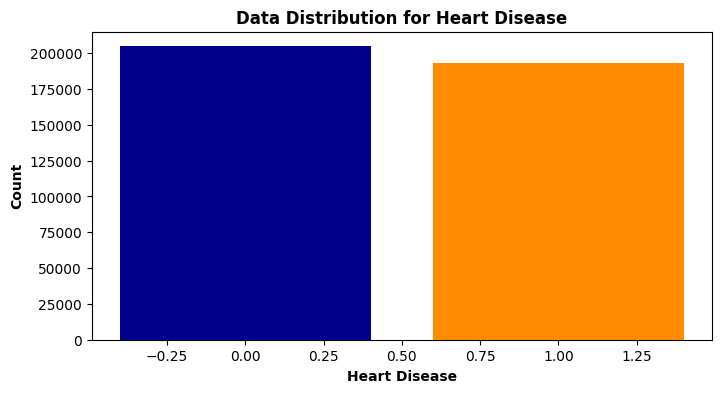

In [83]:
dv.show_bar_graph(df=sc_train_data, 
                  col_="label", 
                  figure_size=(8,4),
                  title='Data Distribution for Heart Disease', 
                  x_label='Heart Disease', 
                  x_tick_rotation=None,
                  bar_color=['darkblue', 'darkorange'])

### __Model Creation and Evaluation__

The  objective is to predict whether an individual has heart disease, which falls under a classification problem. For the model training phase, four distinct classification algorithms are used, namely Logistic Regression, Decision Tree, Random Forest and Gradient-Boosted Tree.

In [84]:
def conduct_crossvalidator(model, param_grid, data):
    """
    Function to conduct crossvalidator on the model using different parameters for hyperparameter tuning
    """
    # Set up cross-validation
    crossval = CrossValidator(  estimator=model,
                                estimatorParamMaps=param_grid,
                                evaluator=BinaryClassificationEvaluator(),
                                numFolds=3)  # You can adjust the number of folds
    # Fit the model
    cv_model = crossval.fit(data)
    # Get the best model
    best_model = cv_model.bestModel
    return best_model


def evaluation_metrics(model, test_data):
    """
    Function to evaluate the model using different classification metrics
    """
    # Make predictions on the testing data
    predictions = model.transform(test_data)

    # Confusion Matrix, Accuracy, Precision, and Recall
    tp = predictions.filter("label = 1 and prediction = 1").count()
    tn = predictions.filter("label = 0 and prediction = 0").count()
    fp = predictions.filter("label = 0 and prediction = 1").count()
    fn = predictions.filter("label = 1 and prediction = 0").count()

    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))

    evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
    area_under_roc = evaluator.evaluate(predictions)
    print("Area Under ROC Curve: {}".format(area_under_roc))

    # Plot confusion matrix
    confusion_matrix = np.array([[tp, fp], [fn, tn]])

    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 11},
                xticklabels=["Actual Positive", "Actual Negative"],
                yticklabels=["Predicted Positive", "Predicted Negative"])

    plt.title('Confusion Matrix', fontweight='bold')
    plt.show()

##### __Logistic Regression__

Logistic regression is a statistical method used for binary classification, predicting the probability of an observation belonging to one of two classes. It models the relationship between the input features and the likelihood of the outcome using the logistic function.

We will use `LogisticRegression` to create logistic regression model, passing the `scaled_features` for input variable and `label` for target variable.

In [85]:
lr = LogisticRegression(featuresCol='scaled_features', labelCol='label')

# Define parameter grid
param_grid = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1, 0.5])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # For regularization type (L1 or L2)
    .build())

LR_model = conduct_crossvalidator(lr, param_grid, sc_train_data)

print("Best regularization parameter: ", LR_model.getRegParam())
print("Best elastic net parameter: ", LR_model.getElasticNetParam())
print("Model: ", LR_model)

Best regularization parameter:  0.01
Best elastic net parameter:  0.0
Model:  LogisticRegressionModel: uid=LogisticRegression_0a9145d76d16, numClasses=2, numFeatures=29


Accuracy: 0.7302383709176453
Precision: 0.1629086465016804
Recall: 0.7314128943758573
Area Under ROC Curve: 0.7307834672407199


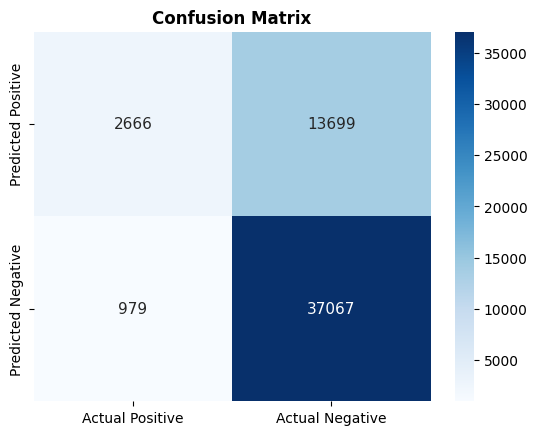

In [86]:
# Evaluate the logistic model using different classification metrics
evaluation_metrics(LR_model, sc_test_data)

##### __Decision Tree Classifier__

A decision tree classifier is a predictive modeling algorithm that recursively partitions data based on feature conditions, constructing a tree-like structure to make sequential decisions and assign classifications to instances. It is widely used for both classification and regression tasks in machine learning.

We will use `DecisionTreeClassifier` to create decision tree classifier model, passing the `scaled_features` for input variable and `label` for target variable.

In [87]:
dt = DecisionTreeClassifier(featuresCol='scaled_features', labelCol='label')

# Define parameter grid
param_grid = (ParamGridBuilder() 
    .addGrid(dt.maxDepth, [5, 10])
    .addGrid(dt.maxBins, [16, 32])
    .addGrid(dt.impurity, ['gini', 'entropy'])
    .build())

DT_model = conduct_crossvalidator(dt, param_grid, sc_train_data)

print("Best max depth: ", DT_model.getMaxDepth())
print("Best max bins: ", DT_model.getMaxBins())
print("Best impurity: ", DT_model.getImpurity())
print("Model: ", DT_model)

Best max depth:  10
Best max bins:  32
Best impurity:  gini
Model:  DecisionTreeClassificationModel: uid=DecisionTreeClassifier_7a4d2d3a2cca, depth=10, numNodes=835, numClasses=2, numFeatures=29


Accuracy: 0.6244876955027476
Precision: 0.12967129936024707
Recall: 0.8063100137174212
Area Under ROC Curve: 0.7088714312372317


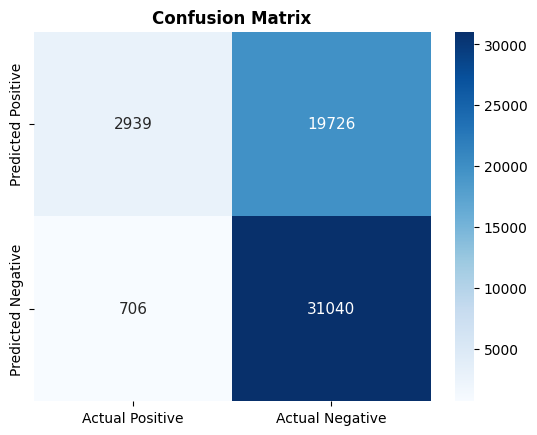

In [88]:
# Evaluate the decision tree model using different classification metrics
evaluation_metrics(DT_model, sc_test_data)

##### __Random Forest Classifier__

A Random Forest classifier is an ensemble learning algorithm that builds multiple decision trees during training and outputs the mode of the classes for classification tasks or the average prediction for regression tasks. It excels in improving predictive accuracy and handling complex relationships in data by combining the outputs of diverse individual trees.

We will use `RandomForestClassifier` to create logistic regression model, passing the `scaled_features` for input variable and `label` for target variable.

In [89]:
rf = RandomForestClassifier(featuresCol='scaled_features', labelCol='label')

# Define parameter grid
param_grid = (ParamGridBuilder() 
    .addGrid(rf.numTrees, [5, 10, 15]) 
    .addGrid(rf.maxDepth, [5, 10]) 
    .addGrid(rf.impurity, ['gini', 'entropy'])
    .build())

RF_model = conduct_crossvalidator(rf, param_grid, sc_train_data)

print("Best number of trees: ", RF_model.getNumTrees)
print("Best max depth: ", RF_model.getMaxDepth())
print("Best impurity: ", RF_model.getImpurity())
print("Model: ", RF_model)

Best number of trees:  15
Best max depth:  10
Best impurity:  gini
Model:  RandomForestClassificationModel: uid=RandomForestClassifier_365d0325e9ff, numTrees=15, numClasses=2, numFeatures=29


Accuracy: 0.7469629302898311
Precision: 0.16544384956044683
Recall: 0.6866941015089163
Area Under ROC Curve: 0.7189921675649218


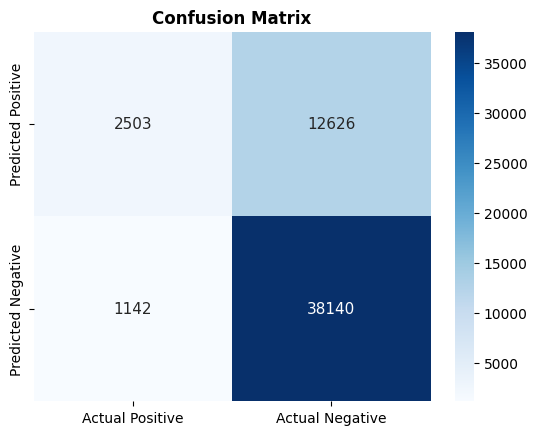

In [90]:
# Evaluate the random forest classifier model using different classification metrics
evaluation_metrics(RF_model, sc_test_data)

##### __Gradient-boosted Tree Classifier__

The Gradient-Boosted Trees (GBT) Classifier is a machine learning algorithm that builds an ensemble of decision trees sequentially, with each subsequent tree correcting the errors of its predecessors. It is particularly effective for both classification and regression tasks, providing high predictive accuracy by combining the outputs of multiple weak learners.

In [91]:
gbt = GBTClassifier(featuresCol='scaled_features', labelCol='label')

# Define parameter grid
param_grid = (ParamGridBuilder() 
    .addGrid(gbt.maxDepth, [5, 10])
    .addGrid(gbt.stepSize, [0.1, 0.5])
    .build())

GBT_model = conduct_crossvalidator(gbt, param_grid, sc_train_data)

print("Best max depth: ", GBT_model.getMaxDepth())
print("Best step size: ", GBT_model.getStepSize())
print("Model: ", GBT_model)

Best max depth:  10
Best step size:  0.5
Model:  GBTClassificationModel: uid = GBTClassifier_ef94b4882996, numTrees=20, numClasses=2, numFeatures=29


Accuracy: 0.7521824631048869
Precision: 0.18491001088836226
Recall: 0.7920438957475995
Area Under ROC Curve: 0.7706821535232502


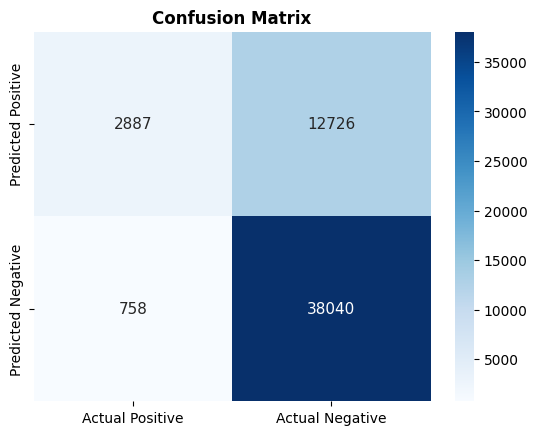

In [92]:
# Evaluate the gradient-boosted trees model using different classification metrics
evaluation_metrics(GBT_model, sc_test_data)

### __Conclusion__

After carefully evaluating various approaches for predicting heart disease with our dataset, we found that the Gradient-Boosted Tree model stands out as the optimal choice. We conducted comparisons with alternative classification algorithms, including Logistic Regression, Random Forest, and Decision Trees, and the table below illustrates the performance of each model.

| Evaluation Metrics   | Logistic Regression | Decision Tree | Random Forest | Gradient-Boosted Tree | 
| -------------------- | ------------------- | ------------- | ------------- | --------------------- | 
| Accuracy             | 73.02%              | 62.09%        | 74.70%        | 75.22%                | 
| Precision            | 16.29%              | 12.90%        | 16.54%        | 18.49%                | 
| Recall               | 73.14%              | 80.63%        | 68.67%        | 79.20%                | 
| Area Under ROC Curve | 73.08%              | 70.89%        | 71.90%        | 77.07%                | 

Gradient-Boosted Tree stands out due to its ability to learn from past mistakes and refine performance over time. Although the performance gap is minimal, even a slight improvement is critical in medical predictions, where accuracy profoundly impacts people's health. Opting for the Gradient-Boosted Tree model in predicting heart disease is a wise decision, emphasizing the importance of selecting a method that, even marginally, enhances the precision and reliability of predictions—especially crucial in healthcare where accuracy, especially recall, is very important.
 
Looking ahead, we think there's still room to enhance Gradient-Boosted Tree model even better. Exploring various parameters for fine-tuning or using more detailed information in our dataset could be beneficial. Additionally, examining other features that were excluded might contribute to a deeper understanding and improvement of predictions.

### __References__

- https://towardsdatascience.com/apache-spark-performance-boosting-e072a3ec1179
- https://medium.com/@adrianchang/apache-spark-checkpointing-ebd2ec065371
- https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221
- https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
- https://towardsdatascience.com/predicting-churn-with-pyspark-ml-d65012e9ab7c
- https://medium.com/@junwan01/oversampling-and-undersampling-with-pyspark-5dbc25cdf253#:~:text=Such%20dataset%20can%20cause%20your,%2C%20generate%20synthetic%20samples%2C%20etc.
- https://towardsdatascience.com/build-an-end-to-end-machine-learning-model-with-mllib-in-pyspark-4917bdf289c5
- https://blog.demir.io/big-data-meets-machine-learning-an-exploration-of-apache-sparks-mllib-fbee889f1d41

### __Group Members__

- Auradee Castro (c0866821)
- Bhumika Rajendra Babu (c0867081) 
- Miraj Sinya (c0863371) 
- Olivia Deguit (c0878491) 
- Roger Mais (c0863147) 